In [40]:
from sirf.STIR import (ImageData, AcquisitionData,
                       SPECTUBMatrix, AcquisitionModelUsingMatrix,
                       MessageRedirector,)
from simind import *
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [41]:
msg = MessageRedirector()
AcquisitionData.set_storage_scheme('memory')

In [42]:
# SIMIND parameters
total_activity = 177 # MBq
time_per_projection = 32 # seconds
photon_multiplier = 0.001
photopeak_energy = 140.5 # keV
window_lower = 126.459 # keV
window_upper = 154.561 # keV
source_type = "tc99m" 
collimator = 'ma-lehr'
kev_per_channel = 1
num_energy_spectra_channels = 200

In [43]:
image = ImageData(os.path.join(os.getcwd(), "data/Tc99m/osem_reconstruction_postfilter_555.hv"))
mu_map = ImageData(os.path.join(os.getcwd(), "/home/sam/working/STIR_users_MIC2023/data/Tc99m/umap_resampled.hv"))
measured_data = AcquisitionData(os.path.join(os.getcwd(), "/home/sam/working/STIR_users_MIC2023/data/Tc99m/peak_stir_en_1_Primary.hdr"))

In [44]:
mu_map_stir = mu_map.clone()
mu_map_stir.fill(np.flip(mu_map.as_array(), axis=2))

In [45]:
create_window_file(window_lower, window_upper, scatter_orders=0, output_filename= "input.win" )

In [46]:
simulator = SimindSimulator(input_filepath=".", output_filepath=".",)
attributes = {"SourceMap": image,
              "MuMap": mu_map,
              "keVPerChannel": kev_per_channel, 
              'NumberOfEnergySpectraChannels': num_energy_spectra_channels,
              "PhotopeakEnergy": photopeak_energy,
              "SourceActivity": total_activity,
              "PhotonMultiplier": photon_multiplier,
              "ImageDurationPerProjection": time_per_projection,
              "SourceType": source_type.lower(),
              "Collimator": collimator,}
simulator.set_template_sinogram(measured_data)
simulator.set_attributes(attributes)

In [47]:
simulator.run_simulation()

Clearing all files in . that could cause trouble...
This includes:
 - .h00, .hs, .a00, .hct, .ict, .bis, .res
if this is not what you want, please cancel this process now.
5
4
3
2
1
removed output_air_w1.a00
removed output.res
removed output_air_w1.h00
removed output_tot_w1.h00
removed output.bis
removed output_tot_w1.hs
removed output_sca_w1.h00
removed tmp_adjus_adjusted.h00
removed output_sca_w2.h00
removed tmp.hs
removed output_sca_w2.hs
removed output_sca_w2.a00
removed output_tot_w1.a00
removed output_sca_w1.a00
removed output_air_w1.hs
removed output_sca_w1.hs
All required attributes are set and ready for simulation.
All relevant files exist in ..
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already

In [48]:
simind_total = simulator.get_output_total()
simind_scatter = simulator.get_output_scatter()
simind_true = simind_total - simind_scatter

Output in ./output_air_w1.hs

Output in ./output_tot_w1.hs

Output in ./output_sca_w1.hs

Output in ./output_sca_w2.hs






In [49]:
acq_matrix = SPECTUBMatrix()
acq_matrix.set_attenuation_image(mu_map_stir)
acq_matrix.set_keep_all_views_in_cache(True)
acq_matrix.set_resolution_model(1.81534, 0.02148, False)
acq_model = AcquisitionModelUsingMatrix(acq_matrix)
acq_model.set_up(measured_data, image)

In [50]:
#stir_forward_projection = acq_model.forward(image)
stir_forward_projection = measured_data.clone()

In [51]:
scaling_factor = measured_data.sum()/simind_total.sum()

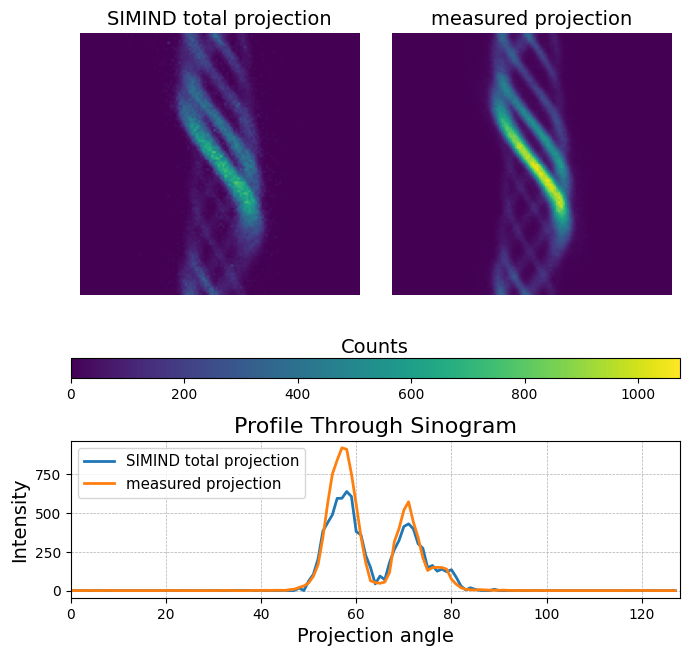

In [52]:
# Define consistent font size and colormap
font_size = 14
colormap = 'viridis'
axial_slice = 97

# Set the maximum intensity for color normalization
vmax = max(measured_data.max(), simind_total.max()*scaling_factor, stir_forward_projection.max())

data_list = [
    (simind_total.as_array()[0, axial_slice]*scaling_factor, "SIMIND total projection"),
    (measured_data.as_array()[0, axial_slice], "measured projection"),
]

# Create a figure and a GridSpec with 3 rows
fig = plt.figure(figsize=(7,6.5))
gs = GridSpec(3, 2, height_ratios=[2, 0.15, 1.2])  # Adjusted GridSpec for clarity

# Create image subplots in the first row
ax_images = [fig.add_subplot(gs[0, i]) for i in range(2)]

for i, (data, title) in enumerate(data_list):
    im = ax_images[i].imshow(data, vmin=0, vmax=vmax, cmap=colormap)
    ax_images[i].set_title(f"{title}", fontsize=font_size)
    ax_images[i].axis('off')

# Place a colorbar in a new row, just for the colorbar
cbar_ax = fig.add_subplot(gs[1, :])  # Spanning across the bottom of the image plots
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', pad=0.02)  # Reduced padding
cbar_ax.set_xlabel('Counts', fontsize=font_size)
cbar_ax.xaxis.set_label_position('top')

# Set consistent font size and line width for the line plot
line_width = 2

# Create line plot in the third row
ax_line = fig.add_subplot(gs[2, :])  # Spanning across both columns in the third row

# Plotting
for i, (data, title) in enumerate(data_list):
    ax_line.plot(data[50], label=title, linewidth=line_width)

# Enhance the appearance of the line plot
ax_line.set_xlabel('Projection angle', fontsize=font_size)
ax_line.set_ylabel('Intensity', fontsize=font_size)
ax_line.set_title(f'Profile Through Sinogram', fontsize=font_size + 2)
ax_line.grid(True, which='both', linestyle='--', linewidth=0.5)
ax_line.legend(loc='upper left', fontsize=font_size/1.3)
# et minimum and maximum values for x-axis
ax_line.set_xlim(0, 128)

# Adjust spacing and layout
plt.tight_layout()
plt.show()

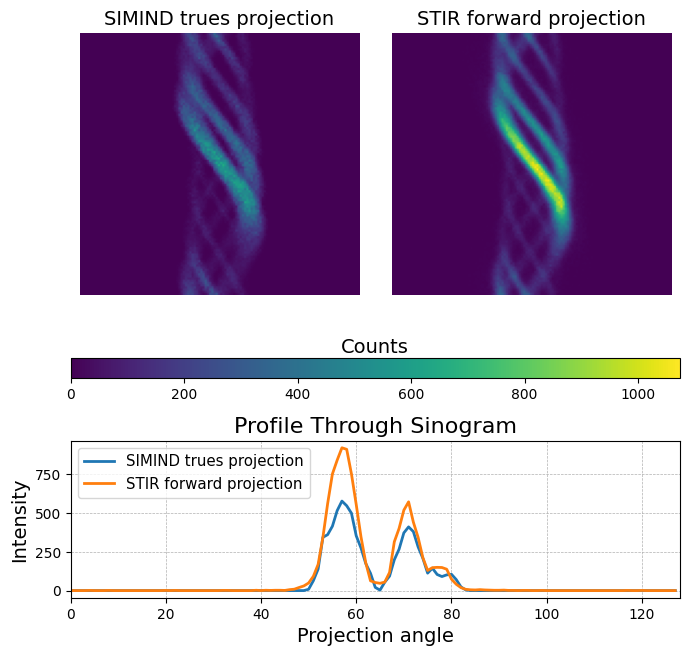

In [53]:
# Set the maximum intensity for color normalization
vmax = max(simind_true.max()*scaling_factor, stir_forward_projection.max())

data_list = [
    (simind_true.as_array()[0, axial_slice]*scaling_factor, "SIMIND trues projection"),
    (stir_forward_projection.as_array()[0, axial_slice], "STIR forward projection")
]

# Create a figure and a GridSpec with 3 rows
fig = plt.figure(figsize=(7,6.5))
gs = GridSpec(3, 2, height_ratios=[2, 0.15, 1.2])  # Adjusted GridSpec for clarity

# Create image subplots in the first row
ax_images = [fig.add_subplot(gs[0, i]) for i in range(2)]

for i, (data, title) in enumerate(data_list):
    im = ax_images[i].imshow(data, vmin=0, vmax=vmax, cmap=colormap)
    ax_images[i].set_title(f"{title}", fontsize=font_size)
    ax_images[i].axis('off')

# Place a colorbar in a new row, just for the colorbar
cbar_ax = fig.add_subplot(gs[1, :])  # Spanning across the bottom of the image plots
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', pad=0.02)  # Reduced padding
cbar_ax.set_xlabel('Counts', fontsize=font_size)
cbar_ax.xaxis.set_label_position('top')

# Set consistent font size and line width for the line plot
line_width = 2

# Create line plot in the third row
ax_line = fig.add_subplot(gs[2, :])  # Spanning across both columns in the third row

# Plotting
for i, (data, title) in enumerate(data_list):
    ax_line.plot(data[50], label=title, linewidth=line_width)

# Enhance the appearance of the line plot
ax_line.set_xlabel('Projection angle', fontsize=font_size)
ax_line.set_ylabel('Intensity', fontsize=font_size)
ax_line.set_title(f'Profile Through Sinogram', fontsize=font_size + 2)
ax_line.grid(True, which='both', linestyle='--', linewidth=0.5)
ax_line.legend(loc='upper left', fontsize=font_size/1.3)
# et minimum and maximum values for x-axis
ax_line.set_xlim(0, 128)

# Adjust spacing and layout
plt.tight_layout()
plt.show()

In [129]:
from numba import jit, prange

@jit(forceobj=True, parallel=True)
def calculate_patch_sums(array, patch_size):
    """
    [Previous docstring...]
    """
    sums = []

    # Calculate sums for regular patches in the central part
    for i in prange(patch_size[0], array.shape[0] - patch_size[0], patch_size[0]):
        for j in prange(patch_size[1], array.shape[1] - patch_size[1], patch_size[1]):
            for k in prange(patch_size[2], array.shape[2] - patch_size[2], patch_size[2]):
                patch = array[i:i+patch_size[0], j:j+patch_size[1], k:k+patch_size[2]]
                sums.append(np.sum(patch))

    # Calculate sum for the continuous edge patch
    # Summing all elements on the outermost layer of the array
    edge_sum = np.sum(array[:patch_size[0], :, :]) + \
               np.sum(array[-patch_size[0]:, :, :]) + \
               np.sum(array[:, :patch_size[1], :]) + \
               np.sum(array[:, -patch_size[1]:, :]) + \
               np.sum(array[:, :, :patch_size[2]]) + \
               np.sum(array[:, :, -patch_size[2]:])

    # Subtracting the corners as they are counted multiple times
    corner_sum = np.sum(array[:patch_size[0], :patch_size[1], :patch_size[2]]) + \
                 np.sum(array[-patch_size[0]:, :patch_size[1], :patch_size[2]]) + \
                 np.sum(array[:patch_size[0], -patch_size[1]:, :patch_size[2]]) + \
                 np.sum(array[-patch_size[0]:, -patch_size[1]:, :patch_size[2]]) + \
                 np.sum(array[:patch_size[0], :patch_size[1], -patch_size[2]:]) + \
                 np.sum(array[-patch_size[0]:, :patch_size[1], -patch_size[2]:]) + \
                 np.sum(array[:patch_size[0], -patch_size[1]:, -patch_size[2]:]) + \
                 np.sum(array[-patch_size[0]:, -patch_size[1]:, -patch_size[2]:])

    edge_sum -= corner_sum

    sums.append(edge_sum)

    return sums


@jit(forceobj=True, parallel=True)
def normalise_patches(reference, floating, patch_size):
    """
    Normalize the patches of one 3D array based on the sum of patches from another 3D array.
    
    [Previous docstring...]
    """
    ref_sums = calculate_patch_sums(reference, patch_size)
    float_sums = calculate_patch_sums(floating, patch_size)

    # Normalising central patches
    for i in prange(patch_size[0], floating.shape[0] - patch_size[0], patch_size[0]):
        for j in prange(patch_size[1], floating.shape[1] - patch_size[1], patch_size[1]):
            for k in prange(patch_size[2], floating.shape[2] - patch_size[2], patch_size[2]):
                idx = ((i // patch_size[0]) * ((floating.shape[0] - 2 * patch_size[0]) // patch_size[0]) * ((floating.shape[1] - 2 * patch_size[1]) // patch_size[1])) + \
                      ((j // patch_size[1]) * ((floating.shape[1] - 2 * patch_size[1]) // patch_size[1])) + \
                      (k // patch_size[2])
                if float_sums[idx] != 0:
                    ratio = ref_sums[idx] / float_sums[idx]
                    floating[i:i+patch_size[0], j:j+patch_size[1], k:k+patch_size[2]] *= ratio

    # Normalising the edge patch
    if len(ref_sums) > 1:  # Checking if there's an edge patch
        edge_ratio = ref_sums[-1] / float_sums[-1] if float_sums[-1] != 0 else 0
        floating[:patch_size[0], :, :] *= edge_ratio
        floating[-patch_size[0]:, :, :] *= edge_ratio
        floating[:, :patch_size[1], :] *= edge_ratio
        floating[:, -patch_size[1]:, :] *= edge_ratio
        floating[:, :, :patch_size[2]] *= edge_ratio
        floating[:, :, -patch_size[2]:] *= edge_ratio

    return floating


def visualise_patches_with_edge(array, slice_index, patch_size):
    """
    Visualize the patches on a 2D slice of the 3D array with a continuous edge patch.

    This function takes a 3D array and patch size, and creates a 2D visualization
    with borders around each patch for one slice of the array. The edge patch is
    highlighted differently.

    Parameters:
    array (numpy.ndarray): The 3D array to be visualized.
    patch_size (tuple): A tuple of three integers specifying the size of the patches along each dimension.

    Returns:
    None: The function directly displays the image.
    """
    slice_2d = array[slice_index, :, :]

    fig, ax = plt.subplots()
    ax.imshow(slice_2d, cmap='gray')

    # Drawing borders around each regular patch
    for i in range(0, array.shape[1] - patch_size[1] + 1, patch_size[1]):
        for j in range(0, array.shape[2] - patch_size[2] + 1, patch_size[2]):
            rect = patches.Rectangle((j, i), patch_size[2], patch_size[1], fill=False, color='red', linewidth=2)
            ax.add_patch(rect)

    # Highlighting the edge patch
    if array.shape[1] % patch_size[1] != 0:
        i = array.shape[1] - array.shape[1] % patch_size[1]
        edge_rect = patches.Rectangle((0, i), array.shape[2], patch_size[1], fill=False, color='blue', linewidth=2, linestyle='--')
        ax.add_patch(edge_rect)

    if array.shape[2] % patch_size[2] != 0:
        j = array.shape[2] - array.shape[2] % patch_size[2]
        edge_rect = patches.Rectangle((j, 0), patch_size[2], array.shape[1], fill=False, color='blue', linewidth=2, linestyle='--')
        ax.add_patch(edge_rect)

    plt.show()


def visualize_patches(array, slice_index, patch_size):
    """
    Visualize the patches on a 2D slice of the 3D array.
    
    [Previous docstring...]
    """
    slice_2d = array[slice_index, :, :]

    fig, ax = plt.subplots()
    ax.imshow(slice_2d, cmap='gray')

    # Drawing borders around each central patch
    for i in range(patch_size[0], slice_2d.shape[0] - patch_size[0], patch_size[0]):
        for j in range(patch_size[1], slice_2d.shape[1] - patch_size[1], patch_size[1]):
            rect = plt.Rectangle((j, i), patch_size[1], patch_size[0], fill=False, color='red', linewidth=2)
            ax.add_patch(rect)

    # Highlighting the edge patch
    ax.add_patch(plt.Rectangle((0, 0), slice_2d.shape[1], slice_2d.shape[0], fill=False, color='blue', linewidth=2))

    plt.show()


In [130]:
patch_normalised_arr = np.expand_dims(normalise_patches(measured_data.as_array()[0], simind_total.as_array()[0], (10, 10, 10)), axis=0)
patch_normalised = measured_data.clone()
patch_normalised.fill(patch_normalised_arr)

IndexError: list index out of range

In [ ]:
print(f"Total counts in measured data: {measured_data.sum()}")
print(f"Total counts in SIMIND data: {simind_total.sum()}")
print(f"Total counts in patch normalised data: {patch_normalised.sum()}")

Total counts in measured data: 5865141.0
Total counts in SIMIND data: 15895253.0
Total counts in patch normalised data: 14002784.0


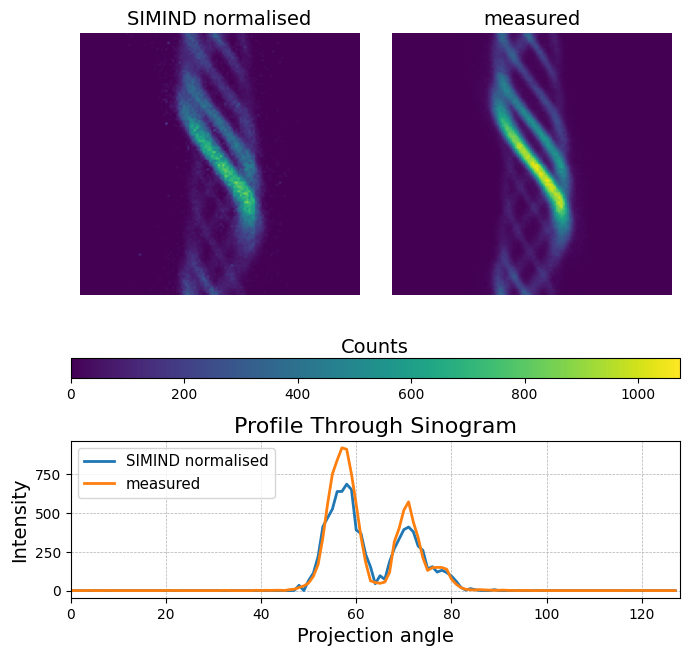

In [92]:
# Set the maximum intensity for color normalization
vmax = max(patch_normalised.max(), stir_forward_projection.max())

data_list = [
    (patch_normalised.as_array()[0, axial_slice], "SIMIND normalised"),
    (measured_data.as_array()[0, axial_slice], "measured"),
]

# Create a figure and a GridSpec with 3 rows
fig = plt.figure(figsize=(7,6.5))
gs = GridSpec(3, 2, height_ratios=[2, 0.15, 1.2])  # Adjusted GridSpec for clarity

# Create image subplots in the first row
ax_images = [fig.add_subplot(gs[0, i]) for i in range(2)]

for i, (data, title) in enumerate(data_list):
    im = ax_images[i].imshow(data, vmin=0, vmax=vmax, cmap=colormap)
    ax_images[i].set_title(f"{title}", fontsize=font_size)
    ax_images[i].axis('off')

# Place a colorbar in a new row, just for the colorbar
cbar_ax = fig.add_subplot(gs[1, :])  # Spanning across the bottom of the image plots
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', pad=0.02)  # Reduced padding
cbar_ax.set_xlabel('Counts', fontsize=font_size)
cbar_ax.xaxis.set_label_position('top')

# Set consistent font size and line width for the line plot
line_width = 2

# Create line plot in the third row
ax_line = fig.add_subplot(gs[2, :])  # Spanning across both columns in the third row

# Plotting
for i, (data, title) in enumerate(data_list):
    ax_line.plot(data[50], label=title, linewidth=line_width)

# Enhance the appearance of the line plot
ax_line.set_xlabel('Projection angle', fontsize=font_size)
ax_line.set_ylabel('Intensity', fontsize=font_size)
ax_line.set_title(f'Profile Through Sinogram', fontsize=font_size + 2)
ax_line.grid(True, which='both', linestyle='--', linewidth=0.5)
ax_line.legend(loc='upper left', fontsize=font_size/1.3)
# et minimum and maximum values for x-axis
ax_line.set_xlim(0, 128)

# Adjust spacing and layout
plt.tight_layout()
plt.show()

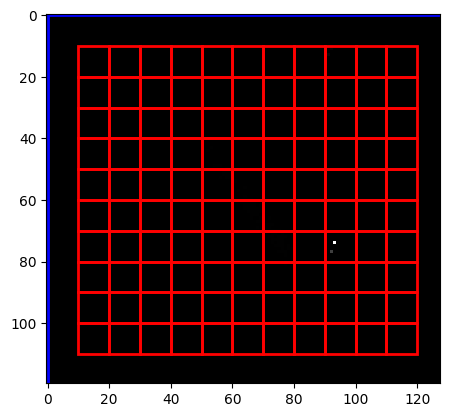

In [124]:
visualize_patches(patch_normalised.as_array()[0], axial_slice, (10, 10, 10))